In [15]:
import cudaq
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ---- Backend ----
cudaq.set_target("qpp-cpu")


In [16]:
# ===========================================
# Data (keep structure close to your snippet)
# ===========================================
df = pd.read_csv("../../data/data.csv")

# Features exclude ID, e_Sint, Sint; target is Sint
features = df.drop(columns=['ID', 'e_Sint', 'Sint'])
target = df['Sint'].values.reshape(-1, 1)

# Fill NaNs with column means (numeric)
num_cols = features.select_dtypes(include=[np.number]).columns
features[num_cols] = features[num_cols].fillna(features[num_cols].mean())

# Scale features to [0,1] then map to angles in [0, pi]
scaler_X = MinMaxScaler()
X_mm = scaler_X.fit_transform(features.values.astype(np.float32))
X_angles = (X_mm * np.pi).astype(np.float32)  # angle encoding domain [0, π]

# Scale target to [-1, 1] so it matches expectation value range
scaler_y = MinMaxScaler(feature_range=(-1.0, 1.0))
y_scaled = scaler_y.fit_transform(target.astype(np.float32)).flatten()

# Train/Test split (same structure)
X_train, X_test, y_train, y_test = train_test_split(
    X_angles, y_scaled, test_size=0.2, random_state=42
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.float32)


In [21]:
def ry(theta, qubit):
    cudaq.ry(theta, qubit)

def rx(theta, qubit):
    cudaq.rx(theta, qubit)

def rz(theta, qubit):
    cudaq.rz(theta, qubit)
    
def cz(theta, qubit):
    cudaq.cz(theta, qubit)

In [22]:
# ===========================================
# Quantum circuit + autograd (pure QNN)
# ===========================================
# Variational circuit:
# - Angle encode each feature on its qubit via RY
# - depth blocks of {RY(θ), RZ(θ)} on each qubit + ring CZ entanglement
@cudaq.kernel
def vqc_kernel(qn: int, x: list[float], theta: list[float], depth: int):
    q = cudaq.qvector(qn)
    # data encoding
    for i in range(qn):
        ry(x[i], q[i])
    k = 0
    for _ in range(depth):
        for i in range(qn):
            ry(theta[k], q[i]); k += 1
            rz(theta[k], q[i]); k += 1
        # ring entanglement
        for i in range(qn - 1):
            cz(q[i], q[i+1])
        cz(q[qn-1], q[0])

def avg_Z_observable(qn: int):
    H = 0.0 * cudaq.spin.z(0)
    for i in range(qn):
        H += cudaq.spin.z(i)
    return (1.0 / float(qn)) * H

class VQExpectation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, thetas: torch.Tensor, x_batch: torch.Tensor, qn: int, depth: int, shift: float):
        """
        thetas: [n_params]
        x_batch: [B, n_qubits]
        returns: [B, 1]
        """
        theta_list = thetas.detach().cpu().numpy().astype(np.float64).tolist()
        OBS = avg_Z_observable(qn)

        # --- Per-sample observe (avoids batched API issues) ---
        exps = []
        for i in range(x_batch.shape[0]):
            xi = x_batch[i].detach().cpu().numpy().astype(np.float64).tolist()
            res = cudaq.observe(vqc_kernel, OBS, qn, xi, theta_list, depth)
            exps.append(res.expectation())

        out = torch.tensor(exps, dtype=torch.float32, device=x_batch.device).view(-1, 1)
        ctx.save_for_backward(thetas, x_batch)
        ctx.qn = qn
        ctx.depth = depth
        ctx.shift = float(shift)
        return out

    @staticmethod
    def backward(ctx, grad_output):
        thetas, x_batch = ctx.saved_tensors
        qn, depth, s = ctx.qn, ctx.depth, ctx.shift
        n_params = thetas.numel()
        grads = torch.zeros_like(thetas)

        base = thetas.detach().clone()
        OBS = avg_Z_observable(qn)

        # Parameter-shift per parameter (per-sample observe)
        for j in range(n_params):
            th_plus  = base.clone(); th_plus[j]  += s
            th_minus = base.clone(); th_minus[j] -= s
            thp = th_plus.cpu().numpy().astype(np.float64).tolist()
            thm = th_minus.cpu().numpy().astype(np.float64).tolist()

            exp_p_list, exp_m_list = [], []
            for i in range(x_batch.shape[0]):
                xi = x_batch[i].detach().cpu().numpy().astype(np.float64).tolist()
                rp = cudaq.observe(vqc_kernel, OBS, qn, xi, thp, depth)
                rm = cudaq.observe(vqc_kernel, OBS, qn, xi, thm, depth)
                exp_p_list.append(rp.expectation()); exp_m_list.append(rm.expectation())

            exp_p = torch.tensor(exp_p_list, dtype=torch.float32, device=x_batch.device).view(-1, 1)
            exp_m = torch.tensor(exp_m_list, dtype=torch.float32, device=x_batch.device).view(-1, 1)
            dE_dtheta = (exp_p - exp_m) / (2.0 * s)                  # [B,1]
            grads[j] = torch.sum(dE_dtheta * grad_output).item()     # ∑_i dL/dE_i * dE_i/dθ_j

        return grads, None, None, None, None

# Pure QNN: only trainable θ, output is expectation in [-1, 1]
class PureQNN(nn.Module):
    def __init__(self, n_qubits, depth=2):
        super().__init__()
        self.n_qubits = n_qubits
        self.depth = depth
        self.n_params = 2 * n_qubits * depth
        self.theta = nn.Parameter(0.01 * torch.randn(self.n_params, dtype=torch.float32))
        self.shift = np.pi / 2.0

    def forward(self, x_angles):  # x_angles: [B, n_qubits]
        exp = VQExpectation.apply(self.theta, x_angles, self.n_qubits, self.depth, self.shift)  # [B,1]
        return exp.view(-1)  # [B]


In [23]:
# ===========================================
# Build & Train (keep a similar train loop)
# ===========================================
n_qubits = 2          # use all features as qubits (you can reduce if needed)
depth    = 2
model    = PureQNN(n_qubits, depth)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

def train_model(model, X_train_t, y_train_t, epochs=30):
    model.train()
    for ep in range(1, epochs+1):
        optimizer.zero_grad()
        yhat = model(X_train_t)              # [N]
        loss = criterion(yhat, y_train_t)    # MSE on scaled targets in [-1,1]
        loss.backward()
        optimizer.step()
        print(f"Epoch {ep}/{epochs}, Loss: {loss.item():.6f}")

train_model(model, X_train_tensor, y_train_tensor, epochs=30)

Epoch 1/30, Loss: 1.077953
Epoch 2/30, Loss: 1.050747
Epoch 3/30, Loss: 1.023890
Epoch 4/30, Loss: 0.997398
Epoch 5/30, Loss: 0.971284
Epoch 6/30, Loss: 0.945560
Epoch 7/30, Loss: 0.920241
Epoch 8/30, Loss: 0.895338
Epoch 9/30, Loss: 0.870862
Epoch 10/30, Loss: 0.846823
Epoch 11/30, Loss: 0.823232
Epoch 12/30, Loss: 0.800096
Epoch 13/30, Loss: 0.777424
Epoch 14/30, Loss: 0.755223
Epoch 15/30, Loss: 0.733499
Epoch 16/30, Loss: 0.712256
Epoch 17/30, Loss: 0.691500
Epoch 18/30, Loss: 0.671233
Epoch 19/30, Loss: 0.651458
Epoch 20/30, Loss: 0.632175
Epoch 21/30, Loss: 0.613386
Epoch 22/30, Loss: 0.595090
Epoch 23/30, Loss: 0.577286
Epoch 24/30, Loss: 0.559971
Epoch 25/30, Loss: 0.543143
Epoch 26/30, Loss: 0.526797
Epoch 27/30, Loss: 0.510930
Epoch 28/30, Loss: 0.495536
Epoch 29/30, Loss: 0.480609
Epoch 30/30, Loss: 0.466143



--- Sint Metrics (scaled [-1,1]) ---
R2: -221.9763641357422
MAE: 0.5506524443626404
RMSE: 0.6615231149344366

--- Sint Metrics (original scale) ---
R2: -221.97640991210938
MAE: 129.22723388671875
RMSE: 155.24639564052686


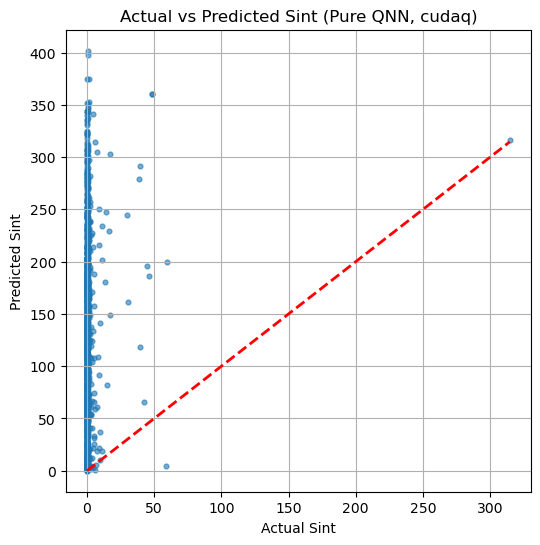

In [20]:
# ===========================================
# Evaluate (scaled & original units)
# ===========================================
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).cpu().numpy().flatten()

print("\n--- Sint Metrics (scaled [-1,1]) ---")
print("R2:",  r2_score(y_test, y_pred_scaled))
print("MAE:", mean_absolute_error(y_test, y_pred_scaled))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_scaled)))

# Inverse scale to original Sint
y_pred_orig = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1,1)).flatten()

print("\n--- Sint Metrics (original scale) ---")
print("R2:",  r2_score(y_test_orig, y_pred_orig))
print("MAE:", mean_absolute_error(y_test_orig, y_pred_orig))
print("RMSE:", np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)))

# Plot
plt.figure(figsize=(6,6))
plt.scatter(y_test_orig, y_pred_orig, s=12, alpha=0.6)
m, M = y_test_orig.min(), y_test_orig.max()
plt.plot([m, M], [m, M], 'r--', lw=2)
plt.xlabel('Actual Sint'); plt.ylabel('Predicted Sint')
plt.title('Actual vs Predicted Sint (Pure QNN, cudaq)')
plt.grid(True); plt.show()